Мне ещё кое-что нужно - аннотация позиций генов.

Задачу нужно делать по выравниванию и для каждой последовательности индивидуально. Мне не важна позиция каждого нуклеотида в последовательности, важна позиция в кодоне. 
В итоге, для каждой веточки пробегается по кодонам, которые были изменены (нужна фиктивная колонка с индексами, чтобы легко выделять позицию в кодоне), собираем информацию о том, что это за мутация (0,1,2 это все, син и фф соотв., так будет легко фильтровать),пишем все в табличку. Отдельно нужно сохранять частоты триплетов и нуклеотидов для каждой родительской ноды.

In [1]:
import re
from queue import Queue
from typing import Iterable
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ete3
from ete3 import PhyloTree
from scipy.stats import entropy
from scipy import spatial

from Bio.Data import CodonTable

import warnings
warnings.filterwarnings("ignore")

In [2]:
path_to_tree = "../data/interim/iqtree_runs/drun1/anc.treefile"
path_to_states = "../data/interim/iqtree_runs/drun1/anc.state"
path_to_leaves = "../data/interim/leaves_nematoda_states_parted.tsv"

In [3]:
tree = tree = PhyloTree(path_to_tree, format=1)

In [4]:
tree.describe()

Number of leaf nodes:	144
Total number of nodes:	286
Rooted:	No
Most distant node:	Meloidogyne_javanica
Max. distance:	5.446504


In [5]:
# print(tree.get_ascii())
# tree.show()

In [6]:
anc = pd.read_csv(path_to_states, sep="\t", comment='#',)
leaves = pd.read_csv(path_to_leaves, sep="\t")

states = pd.concat([anc, leaves]).sort_values(["Node", "Part", "Site"])
print(states.shape)
states.head()

(2866578, 8)


,Node,Part,Site,State,p_A,p_C,p_G,p_T
6516,Acanthocheilonema_viteae,1,1,A,1.0,0.0,0.0,0.0
6517,Acanthocheilonema_viteae,1,2,T,0.0,0.0,0.0,1.0
6518,Acanthocheilonema_viteae,1,3,T,0.0,0.0,0.0,1.0
6519,Acanthocheilonema_viteae,1,4,T,0.0,0.0,0.0,1.0
6520,Acanthocheilonema_viteae,1,5,T,0.0,0.0,0.0,1.0


In [7]:
anc[anc.Node == "Node6"]

,Node,Part,Site,State,p_A,p_C,p_G,p_T
0,Node6,1,1,T,0.03012,0.00375,0.00625,0.95988
1,Node6,1,2,T,0.00001,0.00006,0.00000,0.99993
2,Node6,1,3,G,0.30508,0.02994,0.53229,0.13270
3,Node6,1,4,T,0.00953,0.30213,0.02986,0.65848
4,Node6,1,5,A,0.54912,0.00212,0.40747,0.04130
...,...,...,...,...,...,...,...,...
10018,Node6,5,2936,T,0.00041,0.00338,0.00014,0.99606
10019,Node6,5,2937,T,0.11066,0.06397,0.06969,0.75568
10020,Node6,5,2938,T,0.09209,0.06654,0.06031,0.78106
10021,Node6,5,2939,T,0.00006,0.00063,0.00002,0.99929


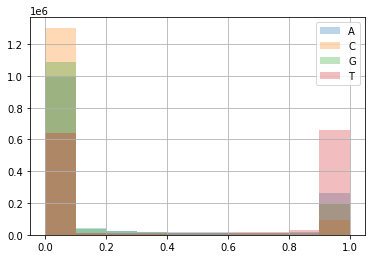

In [8]:
anc.p_A.hist(alpha=.3, label="A")
anc.p_C.hist(alpha=.3, label="C")
anc.p_G.hist(alpha=.3, label="G")
anc.p_T.hist(alpha=.3, label="T")
plt.legend()

## 10% of positions are uncertain

In [9]:
np.any(anc[["p_A", "p_C", "p_G", "p_T"]] > 0.8, 1).value_counts(normalize=True)

True     0.894154
False    0.105846
dtype: float64

In [10]:
mentr = entropy(anc[["p_A", "p_C", "p_G", "p_T"]], axis=1)

Text(0.5, 1.0, 'Entropy')

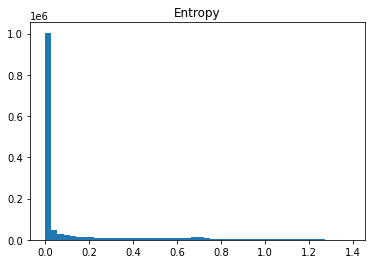

In [11]:
plt.hist(mentr, bins=50)
plt.title("Entropy")

<AxesSubplot:>

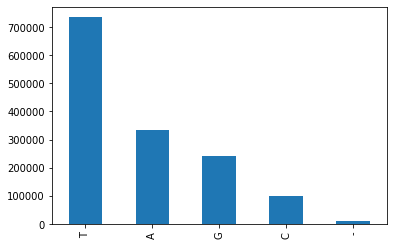

In [12]:
anc.State.value_counts().plot.bar()

## MUTSPEC

In [5]:
mutations = pd.read_csv("../data/processed/nematoda_mutations.csv")
edge_mutspec_all = pd.read_csv("../data/processed/nematoda_mutspec_all.csv")
edge_mutspec_syn = pd.read_csv("../data/processed/nematoda_mutspec_syn.csv")
edge_mutspec_ff = pd.read_csv("../data/processed/nematoda_mutspec_ff.csv")

In [20]:
nonsense_muts = mutations[
    (mutations.Label < 0) & 
    (mutations.Mut.str.fullmatch("[ACGT]>[ACGT]"))
]
nonsense_muts

,RefNode,AltNode,Mut,RefNucl,AltNucl,Label,Pos,PosInCodon,RefCodon,AltCodon,RefAa,AltAa
12,Node1,Philometroides_sanguineus,T>G,T,G,-1,184,1,TAA,GAA,*,E
975,Node1,Philometroides_sanguineus,A>G,A,G,-1,9872,2,TAA,TGA,*,W
1000,Node1,Dracunculus_medinensis,A>T,A,T,-1,185,2,TAA,TTA,*,L
1512,Node1,Dracunculus_medinensis,A>T,A,T,-1,9873,3,TAA,TAT,*,Y
1533,Node1,Node2,A>T,A,T,-1,186,3,TAA,TAT,*,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
80412,Node116,Trichostrongylus_vitrinus,T>A,T,A,-1,7651,1,TAA,AAA,*,K
80970,Node116,Trichostrongylus_axei,A>T,A,T,-1,5094,3,TAA,TAT,*,Y
81190,Node116,Trichostrongylus_axei,T>C,T,C,-1,7651,1,TAA,CAA,*,Q
81673,Node117,Node118,A>T,A,T,-1,7755,3,TAA,TAT,*,Y


In [27]:
_mutations_description = mutations[
    (mutations.RefNucl.isin(list("ACGT"))) &
    (mutations.AltNucl.isin(list("ACGT")))
].groupby("Label").Mut.count().reset_index()
_mutations_description["Label"] = _mutations_description.Label.map(
    {-1: "nonsense", 0: "all", 1: "syn", 2: "syn4f"})

_mutations_description

,Label,Mut
0,nonsense,78
1,all,35638
2,syn,38618
3,syn4f,35132


### Translate MutSpec to heavy strand

(Genes are on Heavy strand, but sequenced Light strand equivalent - mRNA)

In [28]:
translator = str.maketrans("ACGT", "TGCA")


def rev_comp(mut: str):
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

In [29]:
edge_mutspec_all["Mut"] = edge_mutspec_all["Mut"].str.translate(translator)
edge_mutspec_syn["Mut"] = edge_mutspec_syn["Mut"].str.translate(translator)
edge_mutspec_ff["Mut"] = edge_mutspec_ff["Mut"].str.translate(translator)

### Plot mutations and MutSpec

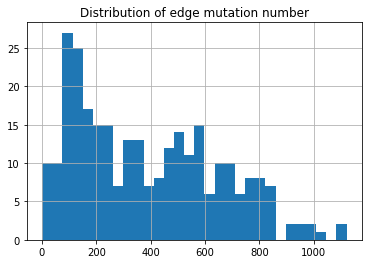

In [30]:
mutations.groupby("AltNode").apply(len).hist(bins=30)
plt.title("Distribution of edge mutation number");

In [31]:
edge_mutspec_all["Label"] = "all"
edge_mutspec_syn["Label"] = "syn"
edge_mutspec_ff["Label"] = "ff"

edge_mutspec = pd.concat([edge_mutspec_all, edge_mutspec_syn, edge_mutspec_ff])
edge_mutspec.head()

,Mut,ObsFr,RefNuc,AltNuc,Divisor,RawMutSpec,MutSpec,RefNode,AltNode,Label
0,A>T,320,T,A,5361,0.059690,0.165013,Node1,Philometroides_sanguineus,all
1,C>T,176,G,A,1678,0.104887,0.289957,Node1,Philometroides_sanguineus,all
2,T>C,147,A,G,1953,0.075269,0.208079,Node1,Philometroides_sanguineus,all
3,A>C,131,T,G,5361,0.024436,0.067552,Node1,Philometroides_sanguineus,all
4,A>G,125,T,C,5361,0.023317,0.064458,Node1,Philometroides_sanguineus,all


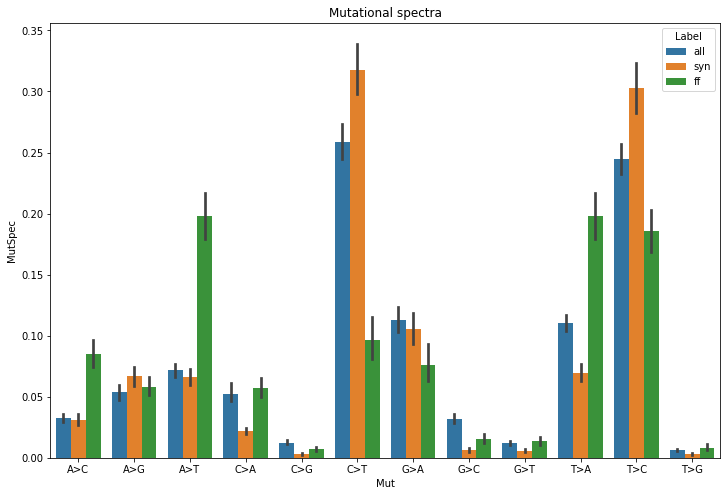

In [20]:
plt.figure(figsize=(12, 8))
sns.barplot(x="Mut", y="MutSpec", hue="Label", data=edge_mutspec, order=sorted(edge_mutspec.Mut.unique()));
plt.title("Mutational spectra")
plt.savefig("../figures/nematoda_mutspec_full.svg")
plt.show()

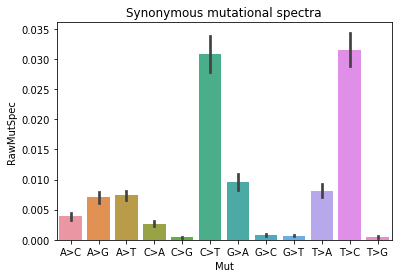

In [17]:
sns.barplot(x="Mut", y="RawMutSpec", data=edge_mutspec_syn, order=sorted(edge_mutspec_syn.Mut.unique()));
plt.title("Synonymous mutational spectra")
plt.savefig("../figures/nematoda_mutspec_syn.svg")
plt.show()

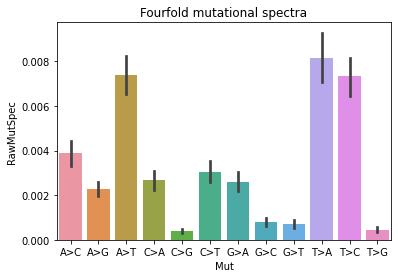

In [18]:
sns.barplot(x="Mut", y="RawMutSpec", data=edge_mutspec_ff, order=sorted(edge_mutspec_ff.Mut.unique()));
plt.title("Fourfold mutational spectra")
plt.savefig("../figures/nematoda_mutspec_ff.svg")
plt.show()

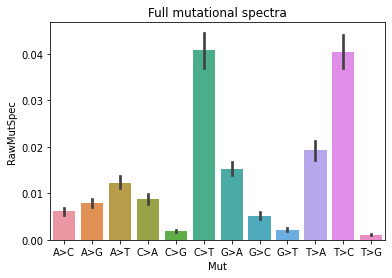

In [20]:
sns.barplot(x="Mut", y="RawMutSpec", data=edge_mutspec_all, order=sorted(edge_mutspec_all.Mut.unique()));
plt.title("Full mutational spectra")
plt.savefig("../figures/nematoda_mutspec_all.svg")
plt.show()

### Prepare edge data for tree vizualisation

In [14]:
def prepare_one_mut_share_file(mutspec: pd.DataFrame, filename: str, sbs="C>T"):
    assert bool(re.match("[ACGT]>[ACGT]", sbs)), "sbs is not appropriate"
    cols = ["RefNode", "AltNode", "MutSpec"]
    for c in cols:
        assert c in mutspec, f"Column {c} is not in mutspec dataframe"
    
    shares = mutspec[mutspec.Mut == sbs][cols]
    shares.to_csv(filename, "\t", index=None)
    return shares


In [27]:
pref_sbs = "C>T"
prepare_one_mut_share_file(edge_mutspec, "../data/processed/c2t_edge_mutspec.tsv")

<AxesSubplot:>

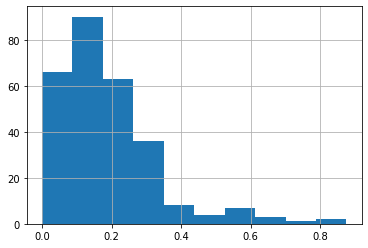

In [23]:
edge_mutspec_ff[edge_mutspec_ff.Mut == "A>G"]["MutSpec"].hist()

### Grouping nodes on tree for everage mutspec

In [32]:
path_to_groups = "../data/interim/nematoda_groups.txt"

_collect_names = False
groups = defaultdict(list)
with open(path_to_groups) as fin:
    for line in fin:
        if line.endswith(")\n"):
            gr_num = int(line.strip(")\n"))
            _collect_names = True
        else:
            if len(line.strip()) == 0:
                _collect_names = False

            if _collect_names:
                name = line.strip().replace(" ", "_")
                groups[gr_num].append(name)


In [33]:
possible_sbs12 = sorted(edge_mutspec_all.Mut.unique())

In [34]:
all_nodes = set(edge_mutspec_all.AltNode)

for gr_num, gr in groups.items():
    for name in gr:
        if name not in all_nodes:
            print(gr_num, name)
print("All nodes found!")

All nodes found!


In [37]:
def get_joined_mutspec(edge_mutspec, groups, sim_cutoff=0.85):
    """ Join mutspec of edges by groups"""
    full_mutspec = []
    for lbl in edge_mutspec.Label.unique():
        print(f"\nLabel: {lbl}")
        edge_mutspec_lbl = edge_mutspec[edge_mutspec.Label == lbl]
        gr_mutspec = []
        for gr_num, gr in groups.items():
            pruned_tree = tree.copy()
            pruned_tree.prune(gr)
            assert len(pruned_tree) == len(gr)

            full_gr = [x.name for x in pruned_tree.iter_descendants()]
            gr_ms = edge_mutspec_lbl[edge_mutspec_lbl["AltNode"].isin(full_gr)]

            separated_ms = []
            for node in full_gr:
                sms = gr_ms[gr_ms["AltNode"] == node].sort_values("Mut")["MutSpec"].values
                separated_ms.append(sms)
            
            to_drop = []
            for sms1, node1 in zip(separated_ms, full_gr):
                one_sims = []
                for sms2, node2 in zip(separated_ms, full_gr):
                    if node1 == node2:
                        continue
                    sim = 1 - spatial.distance.cosine(sms1, sms2)
                    one_sims.append(sim)
                
                if np.mean(one_sims) < sim_cutoff:
                    print(f"Drop node {node1} from group {gr_num} with average similarity to other nodes {np.mean(one_sims):.2f}")
                    to_drop.append(node1)

            full_gr = set(full_gr).difference(to_drop)
            if len(full_gr) < 2:
                continue
            gr_ms = edge_mutspec_lbl[edge_mutspec_lbl["AltNode"].isin(full_gr)]
            gr_ms["Group"] = gr_num
            gr_mutspec.append(gr_ms)
        gr_mutspec_df = pd.concat(gr_mutspec)
        full_mutspec.append(gr_mutspec_df)
    full_mutspec_df = pd.concat(full_mutspec)
    return full_mutspec_df


In [39]:
gr_mutspec = get_joined_mutspec(edge_mutspec, groups)


Label: all
Drop node Node86 from group 1 with average similarity to other nodes 0.82
Drop node Cyathostomum_catinatum from group 1 with average similarity to other nodes 0.85
Drop node Cyathostomum_pateratum from group 1 with average similarity to other nodes 0.85
Drop node Node101 from group 2 with average similarity to other nodes 0.79
Drop node Hypodontus_macropi from group 2 with average similarity to other nodes 0.81
Drop node Oesophagostomum_dentatum from group 2 with average similarity to other nodes 0.85
Drop node Node115 from group 3 with average similarity to other nodes 0.82
Drop node Node70 from group 4 with average similarity to other nodes 0.79
Drop node Metastrongylus_pudendotectus from group 4 with average similarity to other nodes 0.80
Drop node Angiostrongylus_malaysiensis from group 4 with average similarity to other nodes 0.82
Drop node Node124 from group 5 with average similarity to other nodes 0.78
Drop node Node125 from group 5 with average similarity to other n

In [67]:
# mean_mutspec_all = edge_mutspec_all.groupby("Mut").MutSpec.mean().sort_index()
# print("All")
# print("Group\tSimilarity to mean tree MutSpec")
# for gr_num in gr_mutspec_all:
#     ms = gr_mutspec_all[gr_num].sort_values("Mut").MutSpec
#     if len(ms) == 12:
#         sim = 1 - spatial.distance.cosine(ms, mean_mutspec_all)
#         print(f"{gr_num}\t{sim:.2f}")

In [68]:
# mean_mutspec_syn = edge_mutspec_syn.groupby("Mut").MutSpec.mean().sort_index()
# print("Syn")
# print("Group\tSimilarity to mean tree MutSpec")
# for gr_num in gr_mutspec_syn:
#     ms = gr_mutspec_syn[gr_num].sort_values("Mut").MutSpec
#     if len(ms) == 12:
#         sim = 1 - spatial.distance.cosine(ms, mean_mutspec_syn)
#         print(f"{gr_num}\t{sim:.2f}")

In [69]:
# mean_mutspec_ff = edge_mutspec_ff.groupby("Mut").MutSpec.mean().sort_index()
# print("Fourfold")
# print("Group\tSimilarity to mean tree MutSpec")
# for gr_num in gr_mutspec_ff:
#     ms = gr_mutspec_ff[gr_num].sort_values("Mut").MutSpec
#     if len(ms) == 12:
#         sim = 1 - spatial.distance.cosine(ms, mean_mutspec_ff)
#         print(f"{gr_num}\t{sim:.2f}")

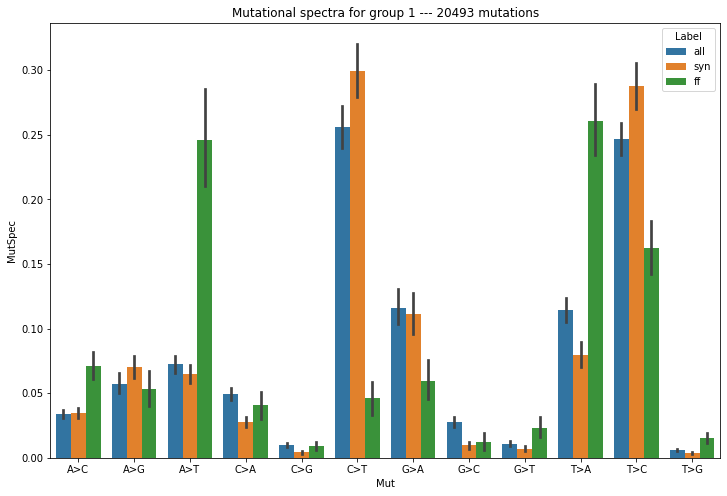

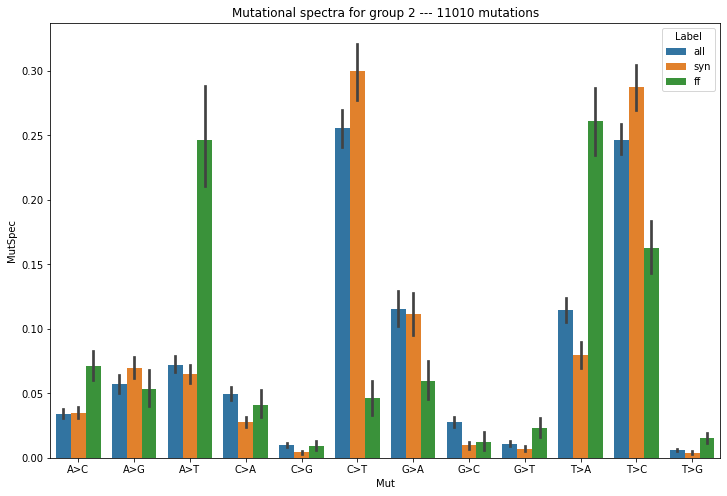

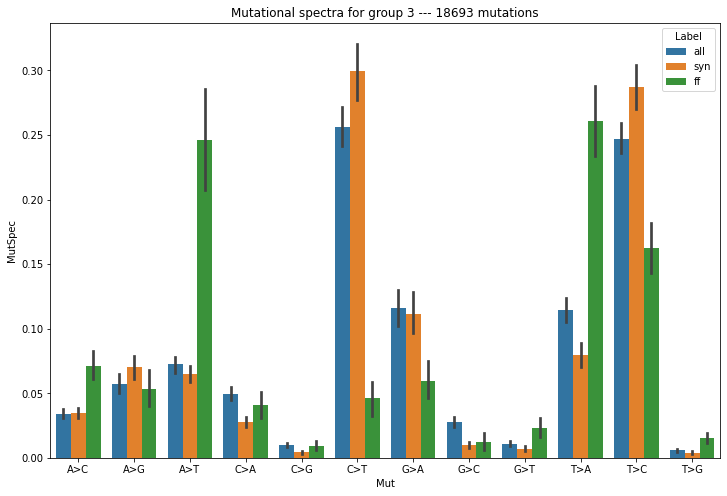

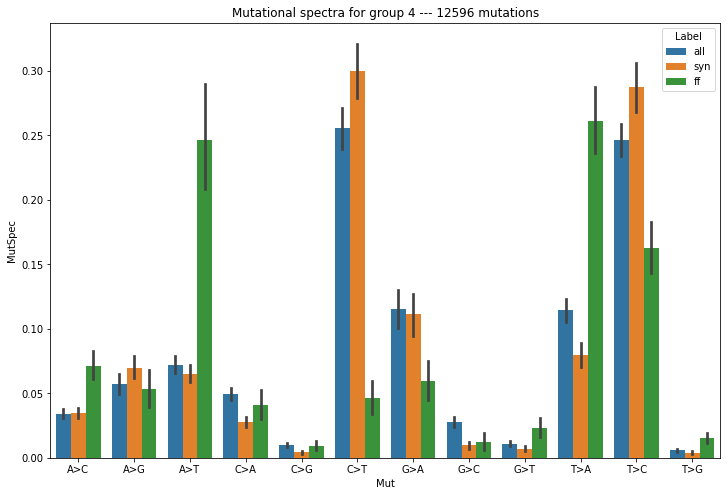

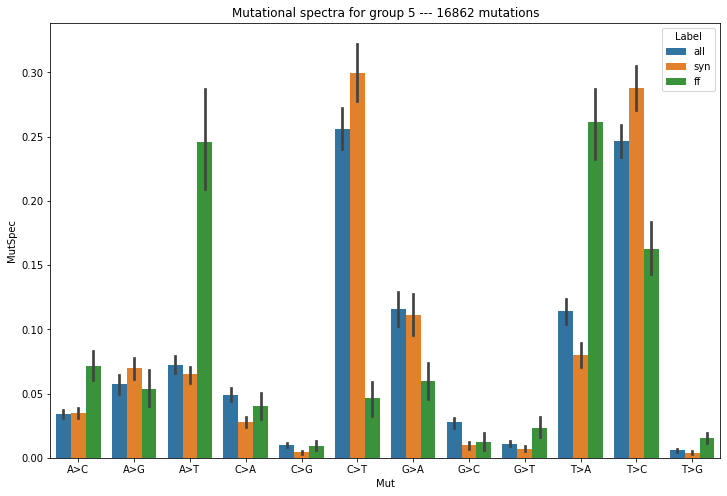

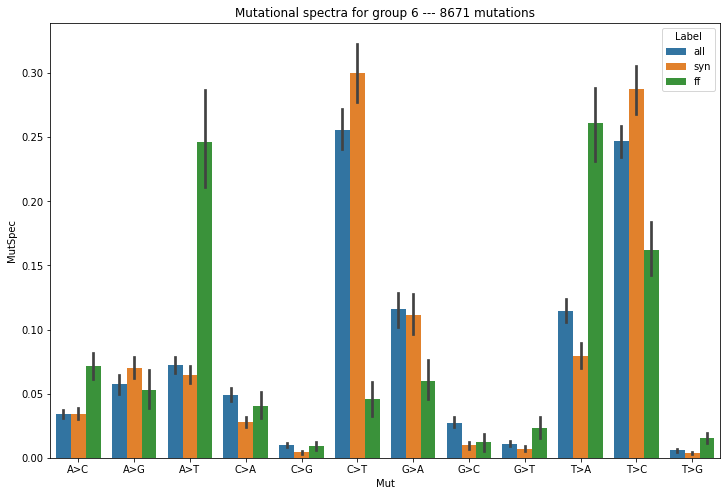

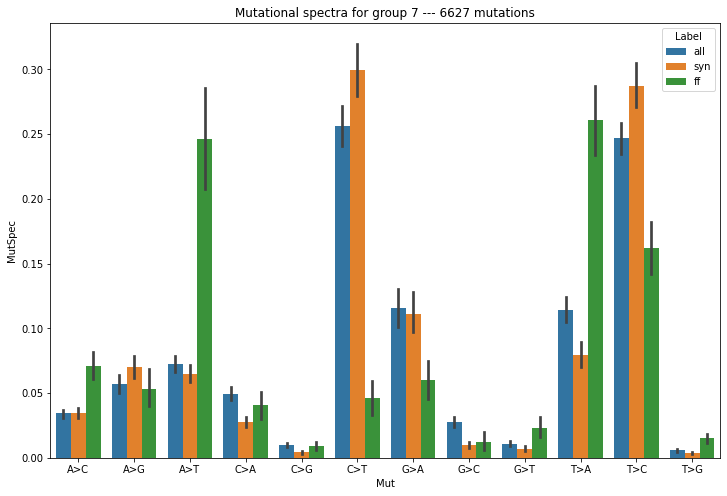

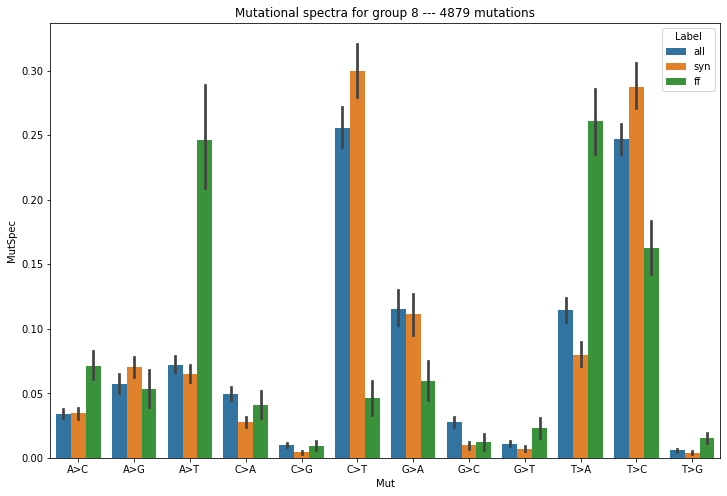

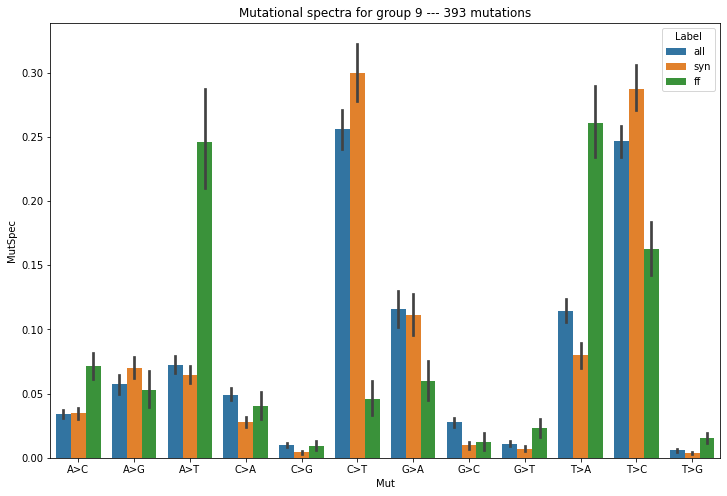

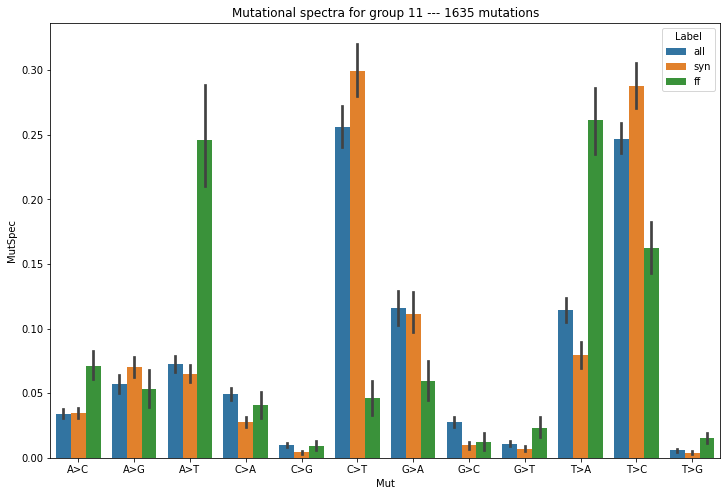

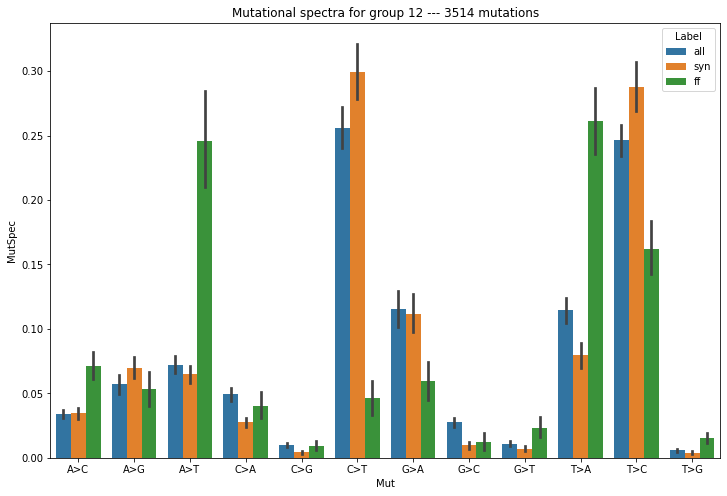

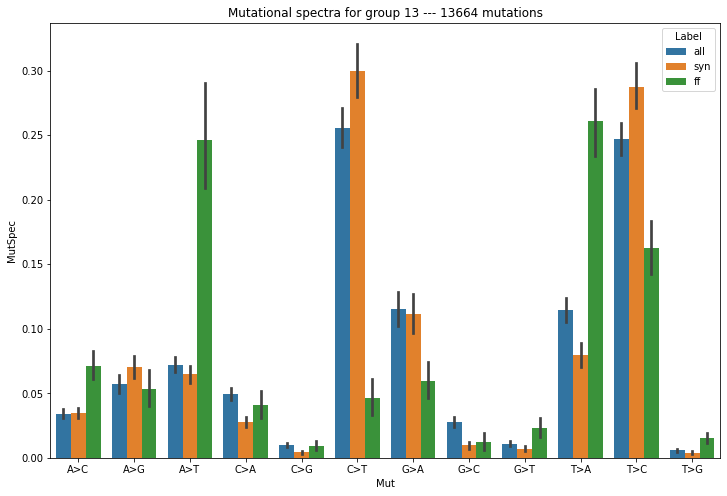

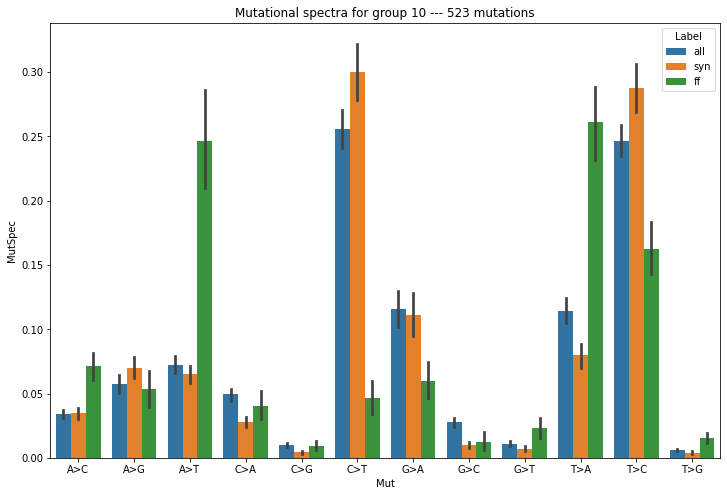

In [40]:
for gr_num in gr_mutspec.Group.unique():
    ms = gr_mutspec[gr_mutspec.Group == gr_num]
    mut_num = ms.ObsFr.sum()
    if mut_num > 50:
        # sns.barplot(x="Mut", y="RawMutSpec", data=ms, order=possible_sbs12)
        # plt.show()
        plt.figure(figsize=(12, 8))
        sns.barplot(x="Mut", y="MutSpec", hue="Label", data=gr_mutspec, order=possible_sbs12)
        plt.title(f"Mutational spectra for group {gr_num} --- {mut_num} mutations")
        plt.show()